<center>
    <h1> Reconocimiento de Patrones en Minería de Datos  </h1>
    <h2> Tarea #1: Beer Clustering</h2>
    <br>
    María Carolina Peña González -  maria.pena@alumnos.usm.cl  -  rol: 2973535-2 
    <br>
    Slavko Cotoras Straub -  slavko.cotoras@alumnos.usm.cl  -  rol: 201104504-1
</center>
</center>

 


## Introducción


Para el desarrollo de esta tarea, se trabajará con el dataset beeradvocate, el cual consiste en una colección de reseñas de cervezas del sitio Beer Advocate, de un periodo de más de 10 años, incluyendo 1.586.614 reseñas hasta noviembre del 2011. Cada reseña tiene 13 características, donde se incluye el id y nombre de brewery, la fecha, el nombre, id y tipo de cerveza,  un ranking de 5 aspectos: apariencia, aroma, paladar, sabor e impresión general.  <br> Con este dataset se probarán 5 algoritmos de clustering, mostrando los resultados obtenidos.

Se listan los tipos de datos a continuación:

        brewery_id           Id de cervecería                             numérico
        brewery_name         Nombre de cervecería                         string
        review_time          Fecha de reseña                              numérico
        review_overall       Impresión general                            numérico 
        review_aroma         Aroma                                        numérico
        review_appearance    Apariencia                                   numérico
        review_profilename   Nombre de perfil                             string
        beer_style           Estilo de cerveza                            string
        review_palate        Paladar                                      numérico
        review_taste         Sabor                                        numérico
        beer_name            Nombre de cerveza                            string
        beer_abv             Alcohol By Volume - Grados de alcohol        numérico
        beer_beerid          Id de cerveza                                numérico

# Desarrollo


In [1]:
# Librerias a usar
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)
import pandas
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn import manifold, metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
#warnings
import warnings
warnings.simplefilter("ignore", UserWarning)
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


Una vez que se conoce el dataset se carga para  para posteriormente analizarlo utilizando diversos algoritmos para realizar el estudio. Debido a problemas de memoria durante el procedimiento de la investigación usando el dataset completo, se procede a hacer uso de una muestra correspondiente al 1%, dicho porcentaje es elegido dado que es el porcentaje más alto en que se pudo realizar el estudio de una buena manera, al aumentar la cantidad de elementos en la muestra del dataset, se presentaba un error en memoria dado la gran cantidad de memoria que requiere para realizar la investigación.
Por otra parte, se inicializan arbitrariamente la cantidad de clusters y el epsilon a utilizar durante el primer análisis de los algoritmos.

In [2]:
#---------------------------------------------------------------------#
#                         Load CSV File                               #
#---------------------------------------------------------------------#

# Se carga el archivo csv
csv_dataframe = pandas.read_csv("beer_reviews.csv", na_values="NaN")

# Se eliminan las filas que contengan algun valor no definido
csv_dataframe = csv_dataframe.dropna()

# Se considera una muestra del dataset
N = 0.01 # Porcentaje de la Muestra del Dataset
X_csv_df = csv_dataframe.sample(frac=N, replace=False)

# Se considera solo los atributos de tipo numericos
X = X_csv_df._get_numeric_data()

# Se eliminan filas que no aporten informacion, dejando sólo los datos de evaluación de 1 a 5.
X = X.drop('brewery_id', 1)
X = X.drop('review_time', 1)
X = X.drop('beer_beerid', 1)

# Los grados de alcohol se consideran como etiqueta numérica, por lo que se trabajará solo los reviews de 1 al 5.
X = X.drop('beer_abv', 1)

n_samples, n_features = X.shape

# Etiquetas presentes en el dataset reducido
etiquetas = X_csv_df.as_matrix()

In [3]:
#---------------------------------------------------------------------#
#                               Seed                                  #
#---------------------------------------------------------------------#
np.random.seed(0)

In [4]:
#---------------------------------------------------------------------#
#                     Visualize the clustering                        #
#---------------------------------------------------------------------#
def plot_clustering(X_red, labels, title=None, cs_subplot=None, subplot=0):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    if subplot is None:
        plt.figure(figsize=(6, 4))
    
    if subplot is not 0:
        plt.subplot(subplot)

    K = len(set(labels))

    for i in range(K):
        plt.plot(
        X_red[np.where(labels == i)[0]][:,0],
        X_red[np.where(labels == i)[0]][:,1],
            'w',
            markerfacecolor=plt.cm.spectral(i / 10.),
            marker= '.'
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout() 

Para poder trabajar con esta información, es necesaria hacer una reducción dimensional, se probaron dos técnicas, PCA y Spectral Embedding, y se decidió trabajar con Spectral Embedding debido a que éste, a pesar de que el tiempo de cómputo es superior a PCA, se obtuvieron mejores resultados. 


In [5]:
#---------------------------------------------------------------------#
#                2D embedding of the digits dataset                   #
#---------------------------------------------------------------------#
X_spectral = manifold.SpectralEmbedding(n_components=2).fit_transform(X)

In [20]:
#---------------------------------------------------------------------#
#                2D embedding of the digits dataset with PCA          #
#---------------------------------------------------------------------#
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Primero es necesario realizar una estandarización
X_std = StandardScaler().fit_transform(X)

# Se reduce la dimensión a dos componentes
pca = PCA(n_components = 2)
pca.fit(X_std) #calcula vp
X_pca = pca.transform(X_std)

A continuación, se muestra una gráfica de cada uno de los algoritmos con los parámetros seteados arbitrariamente. Cada uno de los algoritmos se inicializa con los siguientes parámetros:

    - K-means : número de clusters, opcionales (método de inicialización ,  número de veces que k-means se ejecuta)
    - MiniBatch K-means: Número de clusters ,opcionales (método de inicialización ,  número de veces que k-means se ejecuta)
    - HAC Complete: Número de clusters, afinidad, linkage
    - Ward: Número de clusters, afinidad, linkage
    - DBSCAN: eps, min_samples
Donde K y eps  fueron iniciados de forma arbitraria:

     - K = Número de clusters 
     - EPS = Distancia máxima entre dos muestras del mismo vecindario
    

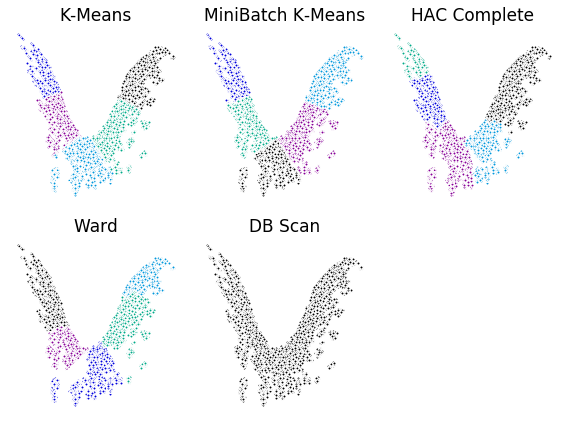

In [21]:
#---------------------------------------------------------------------#
#                     Clustering Parameters                           #
#---------------------------------------------------------------------#

# Clusters
K = 5
#Eps
eps = 0.3

#---------------------------------------------------------------------#
#                               K-Means                               #
#---------------------------------------------------------------------#
k_means = KMeans(init="k-means++", n_clusters=K, n_init=10)
k_means.fit(X_spectral)

plot_clustering(X_spectral, k_means.labels_, "K-Means", subplot=231)

#---------------------------------------------------------------------#
#                         MiniBatch K-Means                           #
#---------------------------------------------------------------------#
mb_k_means = MiniBatchKMeans(n_clusters=K)
mb_k_means.fit(X_spectral)

plot_clustering(X_spectral,  mb_k_means.labels_, "MiniBatch K-Means",1, subplot=232)

#---------------------------------------------------------------------#
#                           HAC Complete                              # 
#---------------------------------------------------------------------#
hac_complete = AgglomerativeClustering(linkage="complete", n_clusters=K, affinity="euclidean")
hac_complete.fit(X_spectral)

plot_clustering(X_spectral,  hac_complete.labels_, "HAC Complete",1, subplot=233)

#---------------------------------------------------------------------#
#                                Ward                                 #
#---------------------------------------------------------------------#
ward = AgglomerativeClustering(linkage="ward", n_clusters=K, affinity="euclidean")
ward.fit(X_spectral)

plot_clustering(X_spectral,  ward.labels_, "Ward",1, subplot=234)

#---------------------------------------------------------------------#
#                           DB Scan                                   #
#---------------------------------------------------------------------#
db_scan = DBSCAN(eps=eps, min_samples=15)
db_scan.fit(X_spectral)

plot_clustering(X_spectral,  db_scan.labels_, "DB Scan",1, subplot=235)

plt.show()

Debido a que estos métodos  trabajan directamente con el número de clusters, y éste parámetro fue seteado de forma arbitraria, se estimará el número de clusters que represente de mejor forma la muestra, para ello, se utilizará Silhouette Score y Elbow Method:

In [46]:
#---------------------------------------------------------------------#
#                   Estimate Number of Clusters                       #
#---------------------------------------------------------------------#

# Rango de Clusters
cluster_range = range(1, 11)

# Elbow Methods Variables
cluster_errors = []

# Silhouette Score Variables
silhouette_rcmd = 0
n_clusters_rcmd = 0
silhouette_array = []

for n_clusters in cluster_range:
    clusters = KMeans(n_clusters)
    clusters.fit(X_spectral)

    cluster_errors.append( clusters.inertia_ )

    # Silhouette Score Restriction
    if(n_clusters == 1):
        continue

    cluster_labels = clusters.fit_predict( X_spectral )
    silhouette_avg = silhouette_score(X_spectral, cluster_labels)
    
    silhouette_array.append(silhouette_avg)

    # Almacena el numero de clusters recomendado
    if silhouette_avg > silhouette_rcmd:
        silhouette_rcmd = silhouette_avg
        n_clusters_rcmd = n_clusters

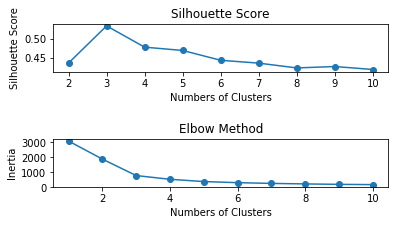

In [52]:
#---------------------------------------------------------------------#
#                    Plot Silhouette Score Graph                      #
#---------------------------------------------------------------------#
clusters_silhouette_df = pandas.DataFrame( { "num_clusters":cluster_range[1:], "silhouette_score": silhouette_array } )

plt.figure(figsize=(6,3))

plt.subplot(311)
plt.plot( clusters_silhouette_df.num_clusters, clusters_silhouette_df.silhouette_score, marker = "o" )
plt.title("Silhouette Score")
plt.xlabel("Numbers of Clusters")
plt.ylabel("Silhouette Score")

#---------------------------------------------------------------------#
#                    Plot Elbow Methods Graph                         #
#---------------------------------------------------------------------#
clusters_elbow_df = pandas.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

plt.subplot(313)
plt.plot( clusters_elbow_df.num_clusters, clusters_elbow_df.cluster_errors, marker = "o" )
plt.title("Elbow Method")
plt.xlabel("Numbers of Clusters")
plt.ylabel("Inertia")
plt.show()

Como se puede ver, utilizando Silhouette Score, se obtiene un mayor puntaje _(0.527547)_  en ${K=3} $, además, utilizando 'Elbow Method', se puede ver que codo se encuentra, igualmente, en en ${K=3} $. Se realizará una comparación de la representación en cada uno de los métodos el nuevo valor obtenido del número de clusters con el valor asignado de forma arbitraria anteriormente. 

In [53]:
#---------------------------------------------------------------------#
#           Re-Computing Algorithms with new Parameters               #
#---------------------------------------------------------------------#

# Clusters
new_K = n_clusters_rcmd

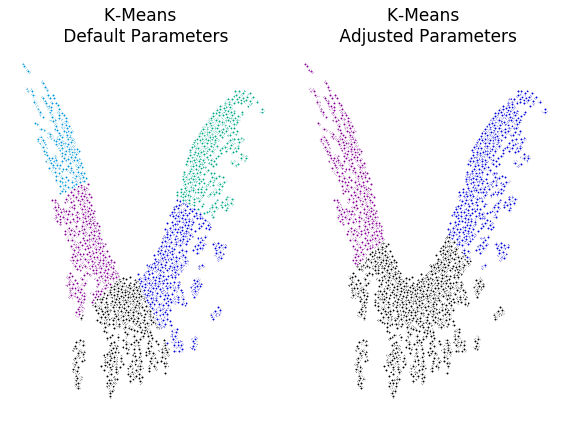

In [54]:
#---------------------------------------------------------------------#
#                            K-Means                                  #
#---------------------------------------------------------------------#
k_means = KMeans(init="random", n_clusters=K, n_init=10)
k_means.fit(X_spectral)

plot_clustering(X_spectral, k_means.labels_, "K-Means \n Default Parameters", subplot = 121)
k_means = KMeans(init="random", n_clusters=new_K, n_init=10)
k_means.fit(X_spectral)
plot_clustering(X_spectral, k_means.labels_, "K-Means \n Adjusted Parameters",subplot  = 122)
plt.show()

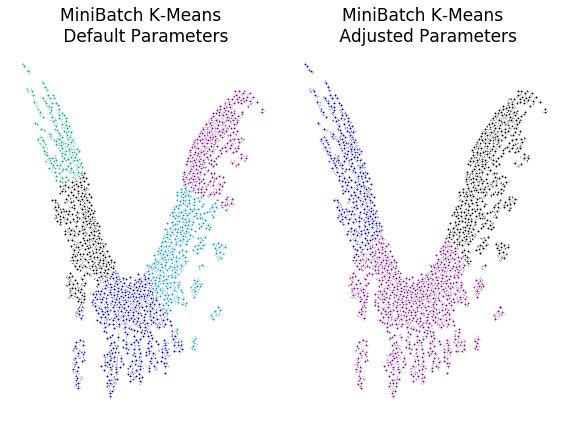

In [55]:
#---------------------------------------------------------------------#
#                         MiniBatch K-Means                           #
#---------------------------------------------------------------------#
mb_k_means = MiniBatchKMeans(n_clusters=K)
mb_k_means.fit(X_spectral)

plot_clustering(X_spectral, mb_k_means.labels_, "MiniBatch K-Means \n Default Parameters", subplot = 121)
mb_k_means = MiniBatchKMeans(n_clusters=new_K)
mb_k_means.fit(X_spectral)

plot_clustering(X_spectral, mb_k_means.labels_, "MiniBatch K-Means \n Adjusted Parameters", subplot = 122)
plt.show()

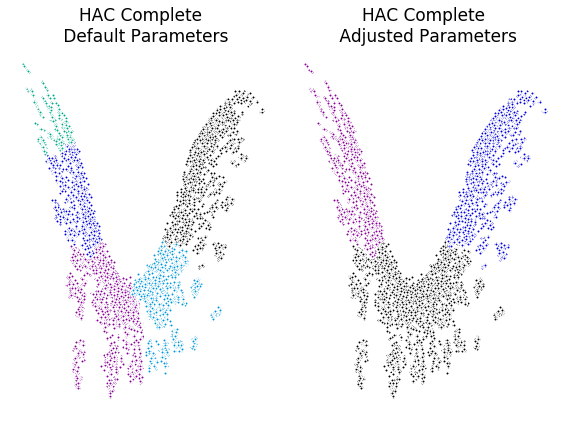

In [56]:
#---------------------------------------------------------------------#
#                           HAC Complete                              # 
#---------------------------------------------------------------------#
hac_complete = AgglomerativeClustering(linkage="complete", n_clusters=K, affinity="euclidean")
hac_complete.fit(X_spectral)

plot_clustering(X_spectral, hac_complete.labels_, "HAC Complete \n Default Parameters", subplot = 121) 
hac_complete = AgglomerativeClustering(linkage="complete", n_clusters=new_K, affinity="euclidean")
hac_complete.fit(X_spectral)

plot_clustering(X_spectral,   hac_complete.labels_, "HAC Complete \n Adjusted Parameters", subplot = 122) 
plt.show()

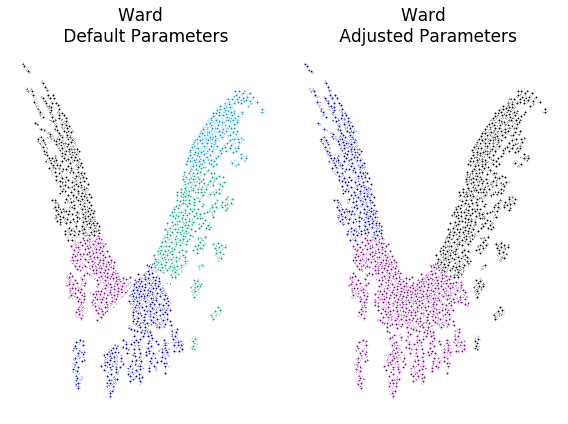

In [57]:
#---------------------------------------------------------------------#
#                                Ward                                 #
#---------------------------------------------------------------------#
ward = AgglomerativeClustering(linkage="ward", n_clusters=K, affinity="euclidean")
ward.fit(X_spectral)

plot_clustering(X_spectral,   ward.labels_, "Ward \n Default Parameters", subplot = 121)
 
ward = AgglomerativeClustering(linkage="ward", n_clusters=new_K, affinity="euclidean")
ward.fit(X_spectral)

plot_clustering(X_spectral,   ward.labels_, "Ward \n Adjusted Parameters", subplot = 122)
plt.show()

Se realizó un dendrograma para HAC y Ward, herramienta que ayuda a decidir de manera visual el número de clusters para representar de mejor forma la estructura de datos, para comparar el resultado obtenido con silhouette score. 

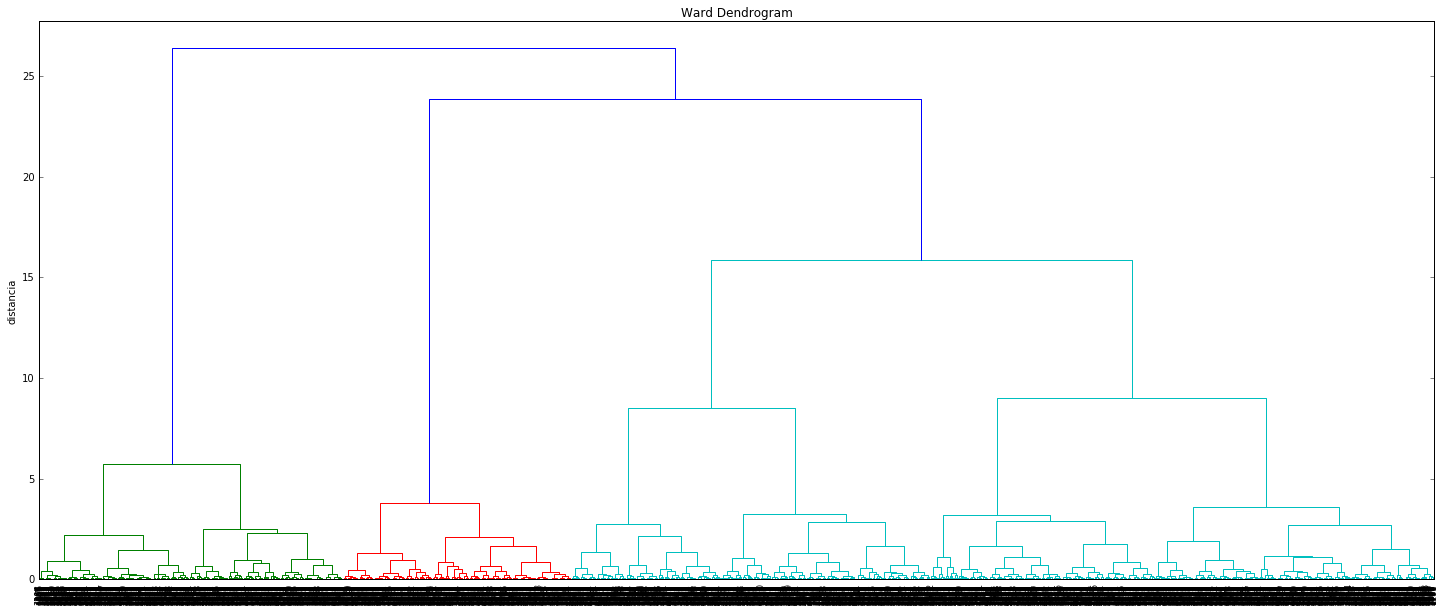

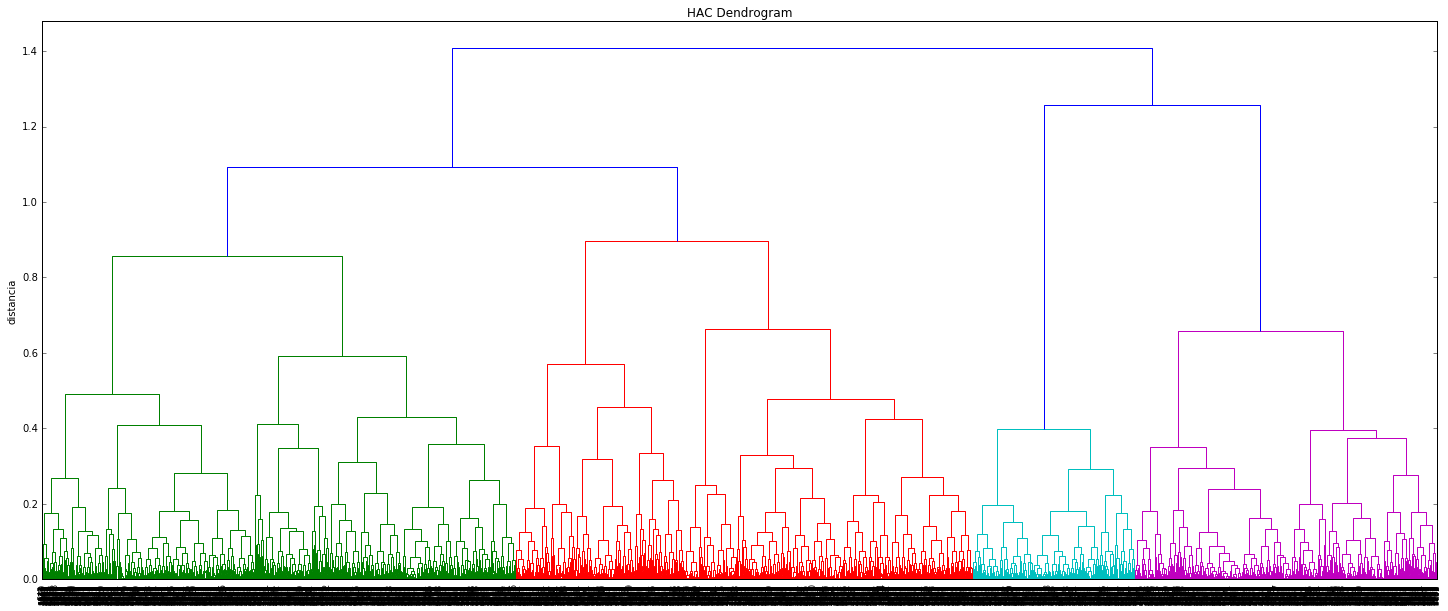

In [24]:
wardZ = linkage(X_spectral, 'ward')
completeZ = linkage (X_spectral, 'complete')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Ward Dendrogram')
plt.ylabel('distancia')
dendrogram(
    wardZ,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

plt.figure(figsize=(25, 10))
plt.title('HAC Dendrogram')
plt.ylabel('distancia')
dendrogram(
    completeZ,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Con esto, se puede ver que si bien en Ward el número de clusters coincide (se pueden distinguir claramente tres clusters realizando un corte a una altura de 15), para el caso de HAC, si  bien, originalmente eran 3 clusters, en el gráfico son visibles 4; esta diferencia se puede explicar por el hecho de no tomar el dataset completo, por esto, los clusters obtenidos no son necesariamente los clusters obtenidos al tener el dataset completo, pues hay conjuntos de datos que no se logran dintinguir con claridad.

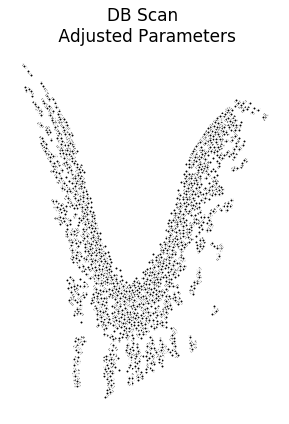

In [6]:
#---------------------------------------------------------------------#
#                           DB Scan                                   #
#---------------------------------------------------------------------#

db_scan = DBSCAN(eps=10, min_samples=305).fit(X_spectral)
plot_clustering(X_spectral,  db_scan.labels_, "DB Scan \n Adjusted Parameters", subplot = 122)
plt.show()

Como se mencionó anteriormente, DBSCAN no depende del número de clusters, y depende del radio máximo y del tamaño minimo de vencindades, a cambio de esto, este método es muy sensible a EPS, por lo que es necesario realizar un análisis más fino. Para ello, una heurística utilizada es "K-dist plots", en donde se calcula la distancia desde el objeto a su k-esimo vecino más cercano. Luego, se grafica la distancia y el ranking, y el punto del codo indica la cantidad de EPS  que garantiza que el codo cubra todos los puntos.

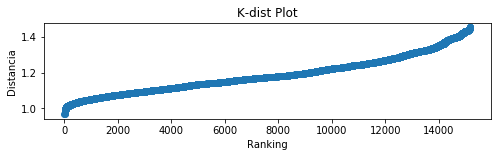

In [8]:
#---------------------------------------------------------------------#
#                    Plot Elbow Methods Graph                         #
#---------------------------------------------------------------------#
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
knn = KNeighborsClassifier()

nrbrs = NearestNeighbors(n_neighbors= len(X)).fit(X_spectral)
distance, indices = nrbrs.kneighbors(X_spectral)

index = np.sort(indices[len(indices)-1])
order = np.sort(distance[:,len(distance)-1])
eps_elbow_df = pandas.DataFrame( { "indice":index,"distancia": order } )

plt.subplot(313)
plt.plot( eps_elbow_df.indice, eps_elbow_df.distancia, marker = "o" )
plt.title("K-dist Plot")
plt.xlabel("Ranking")
plt.ylabel("Distancia")

plt.show()

Con los datos obtenidos, se puede ver que no es posible detectar un codo utilizando el algoritmo, por lo que, nuevamente se ve el problema de no tomar todo el dataset, por lo que no se alcanzan a definir bien los clusters como corresponde. 

Respecto a las etiquetas presentes en el dataset, es posible obtener las métricas para determinar cual de ellas representa mejor los datos ( obteniendo un valor desde 0 a 1), a continuación se calcula el valor de cada método para cada uno de los algoritmos para cada etiqueta:

#### Etiqueta Nombre de Cervecería

In [62]:
labels_true = etiquetas[:,[1]].ravel()


labels_pred = k_means.labels_

print "Métricas usando K-means"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = mb_k_means.labels_

print "\nMétricas usando Minibatch K-means"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = hac_complete.labels_

print "\nMétricas usando HAC Complete"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = ward.labels_

print "\nMétricas usando Ward"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = db_scan.labels_

print "\nMétricas usando DB Scan"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

Métricas usando K-means

Rand Score: 0.00195916926134
Normalized Mutual Info Score: 0.0991307709279
Homogeneity Score: 0.0406159640934
Completeness Score: 0.241946977355
V Measure Score: 0.0695555453548
Fowlkes Mallows Score: 0.0543800816153

Métricas usando Minibatch K-means

Rand Score: 0.00189380730622
Normalized Mutual Info Score: 0.09856791031
Homogeneity Score: 0.0402779949372
Completeness Score: 0.241214413926
V Measure Score: 0.0690294490151
Fowlkes Mallows Score: 0.0544389059826

Métricas usando HAC Complete

Rand Score: 0.00183107156151
Normalized Mutual Info Score: 0.098842465377
Homogeneity Score: 0.040209217507
Completeness Score: 0.242974958667
V Measure Score: 0.0689998508659
Fowlkes Mallows Score: 0.054594873564

Métricas usando Ward

Rand Score: 0.00191760787931
Normalized Mutual Info Score: 0.0965935464648
Homogeneity Score: 0.0399921427939
Completeness Score: 0.233303658339
V Measure Score: 0.0682799602479
Fowlkes Mallows Score: 0.0532491227302

Métricas usando DB Sc

#### Etiqueta TIpo de Cerveza

In [63]:
labels_true = etiquetas[:,[7]].ravel()


labels_pred = k_means.labels_

print "Métricas usando K-means"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = mb_k_means.labels_

print "\nMétricas usando Minibatch K-means"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = hac_complete.labels_

print "\nMétricas usando HAC Complete"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = ward.labels_

print "\nMétricas usando Ward"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = db_scan.labels_

print "\nMétricas usando DB Scan"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

Métricas usando K-means

Rand Score: 0.00543531758601
Normalized Mutual Info Score: 0.0509401275833
Homogeneity Score: 0.0252175109757
Completeness Score: 0.102900583674
V Measure Score: 0.0405078861858
Fowlkes Mallows Score: 0.105643527675

Métricas usando Minibatch K-means

Rand Score: 0.00514127072909
Normalized Mutual Info Score: 0.0501889823674
Homogeneity Score: 0.0247796170819
Completeness Score: 0.101653465538
V Measure Score: 0.03984612095
Fowlkes Mallows Score: 0.105675345223

Métricas usando HAC Complete

Rand Score: 0.00513929394506
Normalized Mutual Info Score: 0.0510046734838
Homogeneity Score: 0.0250695149592
Completeness Score: 0.103770524536
V Measure Score: 0.0403830474964
Fowlkes Mallows Score: 0.106493252124

Métricas usando Ward

Rand Score: 0.0054550840283
Normalized Mutual Info Score: 0.0485872834168
Homogeneity Score: 0.0243054176355
Completeness Score: 0.0971274859468
V Measure Score: 0.0388811276051
Fowlkes Mallows Score: 0.103840516732

Métricas usando DB Sca

#### Etiqueta Grados de Alcohol

In [64]:
labels_true = etiquetas[:,[11]].ravel()


labels_pred = k_means.labels_

print "Métricas usando K-means"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = mb_k_means.labels_

print "\nMétricas usando Minibatch K-means"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = hac_complete.labels_

print "\nMétricas usando HAC Complete"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = ward.labels_

print "\nMétricas usando Ward"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

labels_pred = db_scan.labels_

print "\nMétricas usando DB Scan"

print "\nRand Score:", metrics.adjusted_rand_score(labels_true, labels_pred)
print "Normalized Mutual Info Score:",metrics.normalized_mutual_info_score(labels_true, labels_pred)
print "Homogeneity Score:",metrics.homogeneity_score(labels_true, labels_pred)
print "Completeness Score:",metrics.completeness_score(labels_true, labels_pred)
print "V Measure Score:",metrics.v_measure_score(labels_true, labels_pred)
print "Fowlkes Mallows Score:",metrics.fowlkes_mallows_score(labels_true, labels_pred)

Métricas usando K-means

Rand Score: 0.00293601799492
Normalized Mutual Info Score: 0.0426376781767
Homogeneity Score: 0.0210446315734
Completeness Score: 0.0863864778984
V Measure Score: 0.033844416375
Fowlkes Mallows Score: 0.10368780113

Métricas usando Minibatch K-means

Rand Score: 0.00303576713586
Normalized Mutual Info Score: 0.0426836154364
Homogeneity Score: 0.0210113031566
Completeness Score: 0.0867100442629
V Measure Score: 0.0338259977316
Fowlkes Mallows Score: 0.104535234729

Métricas usando HAC Complete

Rand Score: 0.0028092401029
Normalized Mutual Info Score: 0.0423054418804
Homogeneity Score: 0.0207318369633
Completeness Score: 0.0863285976957
V Measure Score: 0.033434394665
Fowlkes Mallows Score: 0.104887292345

Métricas usando Ward

Rand Score: 0.00334079772599
Normalized Mutual Info Score: 0.0410989295386
Homogeneity Score: 0.0204982398308
Completeness Score: 0.082403270874
V Measure Score: 0.0328298777666
Fowlkes Mallows Score: 0.102675903769

Métricas usando DB Sc

A partir de los datos obtenidos, se puede ver que el de mayor valor es en DBSCAN, con un valor de 1.0 utilizando Completeness Score, con dos de las tres etiquetas, pero, como se explicó anteriormente, DBSCAN no representa correctamente el dataset.
Dejando este valor de lado, la etiqueta que obtiene una mejor evaluación resulta ser "Nombre de cervecería", con un valor máximo de 0.242974958667 con Completeness Score, por lo que se puede especular que es la mejor etiqueta para representar los datos. Para realizar una mejor comparación, además de las etiquetas solicitadas (Tipo de cerveza y nombre de cervecería) se agregó la etiqueta "Grados de Alcohol" a la comparación, pero no resultó ser una mejor representación que las mencionadas anteriormente. 
Por los datos obtenidos, en general es díficil encontrar una etiqueta que sea mejor para representar los datos obtenidos, puesto que no reflejan la totalidad de los datos, por ende, los clusters obtenidos no representan claramente a los clusters que se podrían encontrar en el dataset completo. 